In [1045]:
# activate oxygen_transport environment


import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib.dates as mdates
import matplotlib.colors as colors
from datetime import datetime, timedelta
import scipy
import dask
from dask import delayed, compute
from dask.distributed import Client
import dask.bag as db
import gc
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set_theme(style="whitegrid")

# Import data

In [62]:


osnap_daily = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\Yao velocity grid uncertainty\daily_2020_2022.nc') #daily osnap grids
osnap_daily['TIME'] = pd.to_datetime(osnap_daily.TIME - 719529, unit='D')

osnap = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\OSNAP_2014-2022\OSNAP_Gridded_TSV_201408_202207_2025.nc') #monthly osnap grids
osnap = osnap.sel(LONGITUDE = slice(osnap.LONGITUDE[0], osnap.LONGITUDE[77])).sel(TIME = slice(osnap_daily.TIME[0], osnap_daily.TIME[-1])) #limit to only Labrador Sea

oxygen_grid = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\Ellen RF Grid\gohsnap_doxy_wbias_June16.nc') # oxygen grid



# Calculate oxygen transport with uncertainty

### OSNAP added a small value to each velocity measurment to force the flux grid to sum to 1.6 Sv, the volume flux through Davis Straight. We must do the same to force the flux grid to sum to 0 Sv. 

In [ ]:
#Example sum to 1.6 Sv
print((osnap_daily.sel(TIME = osnap_daily.TIME[2]).velocity * osnap_daily.grid_factor).sum().values*1e-6) #example daily grid
print(np.nansum(osnap.sel(TIME = osnap.TIME[3]).VELO.values * osnap_daily.grid_factor.values)*1e-6) #example monthly grid


-1.6002556559684964
-1.6080418385342097


In [ ]:
# Find small adjustment value that brings monthly volume flux sum to zero. Takes a long time to run, so I saved outputs in following cell.


# osnap_old = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\O2_mol_yr_Oct_19_amoc_isopycnal_with_dx_and_velocity.nc')

# correction = []

# for i in np.arange(len(osnap.TIME)): #for each month
    
#     d = 50
#     correction_guess = np.linspace(-0.001,0.001)

#     print(i)
#     #i = 5
#     while np.abs(d) > 5: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
                
#                 tmp = []  
#                 for ii in correction_guess:
                    
#                     tmp.append(np.nansum((osnap.sel(TIME = osnap.TIME[i]).VELO.values + ii) * osnap_daily.grid_factor.values))   
#                     #tmp.append(np.nansum((osnap_old.sel(time = osnap_old.time[i]).velocity_uncorrected.values + ii) * osnap_daily.grid_factor.values))   
        
#                 ix = np.argmin(np.abs(tmp))
#                 d = np.nanmin(np.abs(tmp))
#                 correction_tmp = correction_guess[ix]
#                 print(i,ix,d)
#                 correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)

#     correction.append(correction_tmp)


#     gc.collect()
    

0
0 38 18299.355845317943
0 0 18271.13998394739
0 0 18241.554084644187
0 0 18211.10555053025
0 0 18182.789328733226
0 0 18153.004021473695
0 0 18122.882704768563
0 0 18094.609005928272
0 0 18064.124269164284
0 0 18034.568063182523
0 0 18006.44834598829
0 0 17975.899451447884
0 0 17946.378017958486
0 0 17918.097690773895
0 0 17887.649156660307
0 0 17858.188140808954
0 0 17829.838284730096
0 0 17799.45927951089
0 0 17769.97173194238
0 0 17741.453743594582
0 0 17711.368173682364
0 0 17681.782274378696
0 0 17653.398532378487
0 0 17623.017518468667
0 0 17591.823717845953
0 0 17565.175686617033
0 0 17534.83719566348
0 0 17503.607192391064
0 0 17476.861045031343
0 0 17446.544377919054
0 0 17415.38237467478
0 0 17388.67099980754
0 0 17358.32588050957
0 0 17327.132079887204
0 0 17300.320344594074
0 0 17270.066414680565
0 0 17238.942262522178
0 0 17212.264654006693
0 0 17181.681993114296
0 0 17150.68983947416
0 0 17124.075256228214
0 0 17093.626722113928
0 0 17062.500441695447
0 0 17033.11119611

In [682]:
correction = np.array([0.0005448044897958878,
    0.0005678051020408986,
    0.0005586595918367722,
    0.0005895271428571315,
    0.000570863061224587,
    0.0005378961224489152,
    0.00054382040816323,
    0.0005601004081633098,
    0.0005668938775510983,
    0.0005608234693878032,
    0.0005774367346938068,
    0.0005625926530612812,
    0.0005569304081632943,
    0.0005452412244897675,
    0.0005418004081632201,
    0.0005679304081633482,
    0.0005790020408162635,
    0.0005472948979591654,
    0.0005777779591836044,
    0.0005826728571428121,
    0.0006176346938774774,
    0.0006621067346938218,
    0.0006441193877551583,
    0.0006289442857142676])



In [66]:
# Apply adjustmnet to each monthly velocity grid 

tmp = []
for i in np.arange(24):
    tmp.append(osnap.sel(TIME = osnap.TIME[i]).VELO + correction[i]) 

osnap['VELO_ZEROSUM'] = (['TIME', 'DEPTH', 'LONGITUDE'], tmp)

# Calculate volume flux and add to dataset

osnap['VOL_FLUX'] = osnap.VELO_ZEROSUM * osnap_daily.grid_factor.values


In [67]:
# test that each month sums to close to 0 m^3/s transport

osnap.VOL_FLUX.sum(dim = 'LONGITUDE').sum(dim='DEPTH')

<xarray.DataArray 'VOL_FLUX' (TIME: 24)>
array([ 0.22806086,  0.08193792, -0.05661578, -2.16433284,  0.4879377 ,
        0.19903428,  0.44142243, -0.80377696,  0.32873165, -0.35350377,
       -0.17284631, -0.13614934, -4.02229739,  1.12820252,  1.44127695,
       -0.81953755,  0.12196262, -0.31455479,  0.36567961, -0.27091807,
        0.75811015, -0.36932843, -0.20825018, -1.0075514 ])
Coordinates:
  * TIME     (TIME) datetime64[ns] 2020-08-01T12:00:00 ... 2022-07-01T12:00:00

### Calculate oxygen transport

$
 T =   \int_{x_w}^{x_e} \int_{z_{min}}^{z_{max}} O_{2} \, v \, dz \, dx
$

Text(0, 0.5, 'Oxygen transport [Tmol/yr]')

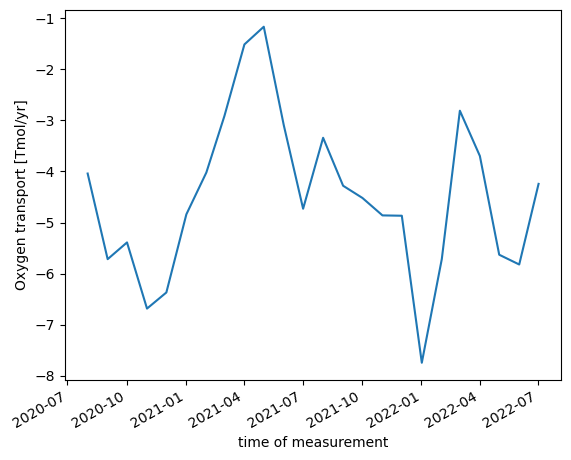

In [81]:
# multiply volume flux in m^3/s by oxygen grid in mol/m^3
# convert from oxygen grid in umol/kg to mol/m^3 by multiplying by density 
# add DSOW bias correction
# convert from mol/y to Tmol/yr: * 1e-6 * 3.15576e+7 *1e-12 

osnap['OXY_TRANSPORT'] = osnap.VOL_FLUX * (oxygen_grid.DOXY*oxygen_grid.SIGMA0 + oxygen_grid.DOXY_BIAS_WOA*oxygen_grid.SIGMA0).values * 1e-6 * 3.15576e+7 *1e-12 

osnap.OXY_TRANSPORT.sum(dim = 'LONGITUDE').sum(dim='DEPTH').plot()
plt.ylabel('Oxygen transport [Tmol/yr]')

### Calculate integral time scale of daily velocity

In [40]:


def autocorrelation(x):
    """Calculate the autocorrelation function of a 1D array."""
    n = len(x)
    x = x - np.nanmean(x)
    result = np.correlate(x, x, mode='full') / np.nanvar(x) / n #normalize by variance. Division by n accounts for overlapping points, produces avreage correlation at each lag instead of sum
    return result[n - 1:] #splits at the maximum

def integral_time_scale(time_series, sampling_interval=1):
    """
    Calculate the integral time scale for each (depth, distance) location
    in a 3D time series (time, depth, distance).
    """
    n_depths = time_series.shape[1]
    n_distances = time_series.shape[2]
    
    # Initialize array
    integral_time_scales = np.zeros((n_depths, n_distances))
    
    # Loop over each depth and distance
    for i in range(n_depths):
        for j in range(n_distances):
            # Get the time series for this (depth, distance) location
            ts = time_series[:, i, j]
            ts = pd.Series(ts).interpolate(method='linear', limit_direction='both').to_numpy() #interpolate over nans
            # Compute the autocorrelation


            acf = autocorrelation(ts)


            # Check if there is any zero crossing
            
            tmp = acf #check whole time series
            zero_crossing = np.argwhere(tmp<0)

            if zero_crossing.size > 0:
                zero_crossing = np.argwhere(tmp<0)[0][0] #first point where reaches zero
                
            else:
                zero_crossing = len(acf) #defaults to length of time series

            integral_time = np.trapz(acf[:zero_crossing + 1]) #take integral up to zero crossing point
            
            # Convert to physical time units
            integral_time_scales[i, j] = integral_time * sampling_interval #1 day for daily grid
    
    return integral_time_scales

tau = integral_time_scale(osnap_daily.velocity)

C:\Users\bikbe\AppData\Local\Temp\ipykernel_26140\923698022.py:4: RuntimeWarning: Mean of empty slice
  x = x - np.nanmean(x)
C:\Users\bikbe\AppData\Local\Temp\ipykernel_26140\923698022.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = np.correlate(x, x, mode='full') / np.nanvar(x) / n #normalize by variance. Division by n accounts for overlapping points, produces avreage correlation at each lag instead of sum


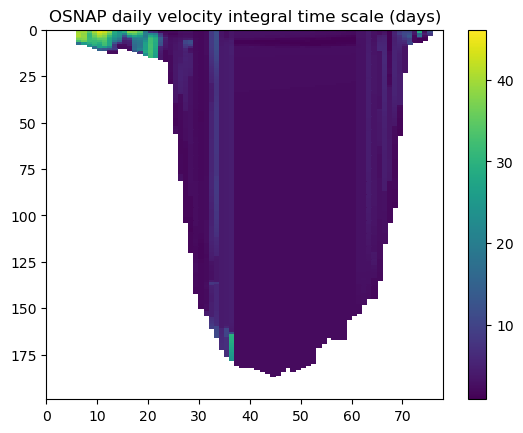

In [153]:
plt.title('OSNAP daily velocity integral time scale (days)')
plt.pcolor(tau)
plt.gca().invert_yaxis()
plt.colorbar()

### Estimate uncertainties with Monte Carlo

In [586]:

#https://statisticsbyjim.com/probability/monte-carlo-simulation/

tmp2=[] 

tmp3=[] 

tmp4 = []

for ii in np.arange(100): #50000
    tmp = []
    tmp_a = []
    tmp_b = []

    days_in_month = osnap_daily.velocity.resample(TIME='M').count().max(dim = 'DEPTH').max(dim = 'LONGITUDE')
    V_std = osnap_daily.velocity.resample(TIME='M').std()

    #err_ratio_full = osnap_daily.velocity.resample(TIME='M').std()/osnap_daily.velocity.resample(TIME='M').mean().values

    for i in np.arange(24):

        # oxygen grid with DSOW correciton added. Multiplied by density to convert from umol/kg to umol/m3
        oxygen = (oxygen_grid.DOXY.sel(TIME = oxygen_grid.TIME[i]).values + oxygen_grid.DOXY_BIAS_WOA.sel(TIME = oxygen_grid.TIME[i].values))*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
        oxygen_error = oxygen_grid.DOXY_ERROR_TOTAL.sel(TIME = oxygen_grid.TIME[i]).values*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
        #oxy_montecarlo = np.random.normal(oxygen, oxygen_error) # select random grid realization from normal distribution
        oxy_montecarlo = oxygen + oxygen_error*np.random.normal(size=oxygen.shape)
        
        #vflux = (osnap_daily.flux_m3_s_velo_corrected).sel(time = timeslice).mean(dim='time') #average daily volume flux grid over month. 
        V = osnap.VELO_ZEROSUM.sel(TIME = osnap.TIME[i]) 
        V_error = V_std.sel(TIME = V_std.TIME[i])/np.sqrt(days_in_month[i].values/(2*tau))
        V_error = V_error.where(np.abs(V_error)<1) #cap error at 100%
        
        V_montecarlo = V + V_error.values*np.random.normal(size=V.shape)
        #V_montecarlo = V + V_std_error.values*np.random.randn(1)

        #O2_transport = ((oxy_montecarlo*1e-6 * V_montecarlo * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12 

        O2_transport = ((oxy_montecarlo.values*1e-6 * V_montecarlo.values * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12 
        
        O2_transport_oxy_only = ((oxy_montecarlo.values*1e-6 * V * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12  # error due to oxygen only

        V_transport = ((V_montecarlo.values * osnap_daily.grid_factor.values.reshape(1,78))) * 1e-6  # error due to oxygen only


        tmp.append(np.nansum(O2_transport))
        tmp_a.append(np.nansum(O2_transport_oxy_only))
        tmp_b.append(np.nansum(V_transport))
        
    tmp2.append(tmp)

    tmp3.append(tmp_a)

    tmp4.append(tmp_b)

    if ii % 10 == 0:
        gc.collect()

    if ii % 100 == 0:
        print(ii)
#plt.plot(tmp2)
print(np.nanmean(tmp2))
print(np.nanstd(tmp2))

0
-4.440957189929478
4.404410357055545


In [601]:
d = 5
correction = []

tmp = []
d = 50
correction_guess = np.linspace(-0.001,0.001)

print(i)
#i = 5
while np.abs(d) > 5: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
            
            tmp = []  
            for ii in correction_guess:
                
                tmp.append(np.nansum((V_montecarlo + ii) * osnap_daily.grid_factor.values))   
                #tmp.append(np.nansum((osnap_old.sel(time = osnap_old.time[i]).velocity_uncorrected.values + ii) * osnap_daily.grid_factor.values))   
    
            ix = np.argmin(np.abs(tmp))
            d = np.nanmin(np.abs(tmp))
            correction_tmp = correction_guess[ix]
            print(i,ix,d)
            correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)

correction.append(correction_tmp)


49
49 21 54239.49143639789
49 49 54210.052599593415
49 49 54180.61376279022
49 49 54151.17492598528
49 49 54121.73608917894
49 49 54092.297252372955
49 49 54062.85841557081
49 49 54033.419578768895
49 49 54003.98074196256
49 49 53974.541905156104
49 49 53945.10306835093
49 49 53915.6642315482
49 49 53886.22539474408
49 49 53856.78655793925
49 49 53827.34772113152
49 49 53797.90888432972
49 49 53768.47004752385
49 49 53739.03121072182
49 49 53709.59237391653
49 49 53680.15353711415
49 49 53650.71470030653
49 49 53621.275863501825
49 49 53591.837026697234
49 49 53562.39818989427
49 49 53532.95935308933
49 49 53503.520516283344
49 49 53474.08167947736
49 49 53444.64284267451
49 49 53415.2040058733
49 49 53385.765169067774
49 49 53356.32633226027
49 49 53326.88749545789
49 49 53297.44865865202
49 49 53268.00982184813
49 49 53238.57098504319
49 49 53209.132148240926
49 49 53179.693311433424
49 49 53150.254474629066
49 49 53120.8156378268
49 49 53091.376801023725
49 49 53061.937964217504
49 

In [653]:

d = 1e10
correction_guess = np.linspace(-0.001,0.001)


#i = 5
while np.abs(d) > 10000: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
            
            tmp_sum = []  
            for c_i in correction_guess:
                
                tmp_sum.append(np.nansum((V_montecarlo + c_i) * osnap_daily.grid_factor.values))   
                
    
            ix = np.argmin(np.abs(tmp_sum))
            d = np.nanmin(np.abs(tmp_sum))
            correction = correction_guess[ix]
            
            correction_guess = np.linspace(correction_guess[ix] - 0.0001 , correction_guess[ix] + 0.0001)

            print(d)

while np.abs(d) > 50: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
            
            tmp_sum = []  
            for c_i in correction_guess:
                
                tmp_sum.append(np.nansum((V_montecarlo + c_i) * osnap_daily.grid_factor.values))   
                
    
            ix = np.argmin(np.abs(tmp_sum))
            d = np.nanmin(np.abs(tmp_sum))
            correction = correction_guess[ix]
            
            correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)

            print(d)

25671500.020433657
25377110.79405163
25082721.567669593
24788332.341287564
24493943.11490553
24199553.888523504
23905164.662141476
23610775.43575944
23316386.20937741
23021996.982995376
22727607.75661335
22433218.53023132
22138829.30384929
21844440.07746726
21550050.851085227
21255661.6247032
20961272.39832117
20666883.17193914
20372493.94555711
20078104.719175078
19783715.49279305
19489326.26641102
19194937.040028986
18900547.813646957
18606158.58726493
18311769.360882897
18017380.13450087
17722990.908118833
17428601.681736812
17134212.45535478
16839823.228972744
16545434.002590716
16251044.77620868
15956655.549826652
15662266.32344462
15367877.097062584
15073487.870680558
14779098.644298524
14484709.417916493
14190320.191534463
13895930.96515243
13601541.738770403
13307152.512388369
13012763.286006337
12718374.059624305
12423984.833242275
12129595.606860245
11835206.380478213
11540817.15409618
11246427.927714145
10952038.701332116
10657649.474950086
10363260.248568054
10068871.022186

In [643]:
# bring volume flux to zero each time

# individual uncertainties

#https://statisticsbyjim.com/probability/monte-carlo-simulation/

tmp2=[] 

tmp3=[] 

tmp4 = []

for ii in np.arange(13): #50000
    tmp = []
    tmp_a = []
    tmp_b = []

    days_in_month = osnap_daily.velocity.resample(TIME='M').count().max(dim = 'DEPTH').max(dim = 'LONGITUDE')
    V_std = osnap_daily.velocity.resample(TIME='M').std()

    #err_ratio_full = osnap_daily.velocity.resample(TIME='M').std()/osnap_daily.velocity.resample(TIME='M').mean().values

    for i in np.arange(24):
        
        # oxygen grid with DSOW correciton added. Multiplied by density to convert from umol/kg to umol/m3
        oxygen = (oxygen_grid.DOXY.sel(TIME = oxygen_grid.TIME[i]).values + oxygen_grid.DOXY_BIAS_WOA.sel(TIME = oxygen_grid.TIME[i].values))*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
        oxygen_error = oxygen_grid.DOXY_ERROR_TOTAL.sel(TIME = oxygen_grid.TIME[i]).values*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
        oxy_montecarlo = np.random.normal(oxygen, oxygen_error) # select random grid realization from normal distribution
        #oxy_montecarlo = oxygen + oxygen_error*np.random.normal(size=oxygen.shape)
        
        #vflux = (osnap_daily.flux_m3_s_velo_corrected).sel(time = timeslice).mean(dim='time') #average daily volume flux grid over month. 
        V = osnap.VELO.sel(TIME = osnap.TIME[i]) 
        V_error = V_std.sel(TIME = V_std.TIME[i])/np.sqrt(days_in_month[i].values/(2*tau))
        V_error = V_error.where(np.abs(V_error)<1) #cap error at 100%
        
        #V_montecarlo = V + V_error.values*np.random.normal(size=V.shape)
        V_montecarlo = V + V_error.values*np.random.normal()

        # Volume flux must sum to zero      
        
        d = 50
        correction_guess = np.linspace(-0.001,0.001)

        
        #i = 5
        while np.abs(d) > 5: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
                    
                    tmp_sum = []  
                    for c_i in correction_guess:
                        
                        tmp_sum.append(np.nansum((V_montecarlo + c_i) * osnap_daily.grid_factor.values))   
                        
            
                    ix = np.argmin(np.abs(tmp_sum))
                    d = np.nanmin(np.abs(tmp_sum))
                    correction = correction_guess[ix]
                   
                    correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)

        


        
    

        O2_transport = ((oxy_montecarlo.values*1e-6 * (V_montecarlo.values + correction) * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12 
        
        O2_transport_oxy_only = ((oxy_montecarlo.values*1e-6 * V * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12  # error due to oxygen only

        V_transport = (((V_montecarlo.values + correction)  * osnap_daily.grid_factor.values.reshape(1,78))) * 1e-6  # error due to oxygen only


        tmp.append(np.nansum(O2_transport))
        tmp_a.append(np.nansum(O2_transport_oxy_only))
        tmp_b.append(np.nansum(V_transport))
        
    tmp2.append(tmp)

    tmp3.append(tmp_a)

    tmp4.append(tmp_b)

    if ii % 2 == 0:
    
        gc.collect()

    if ii % 1 == 0:
        print(ii)
#plt.plot(tmp2)
print(np.nanmean(tmp2))
print(np.nanstd(tmp2))

KeyboardInterrupt: 

In [665]:
from scipy.optimize import brentq

def flux_sum(c):
    return np.nansum((V_montecarlo + c) * osnap_daily.grid_factor.values)

try:
    correction = brentq(flux_sum, -0.01, 0.01)  # bounds must bracket the root
except ValueError:
    correction = 0  # fallback if root not bracketed

correction

-0.00645901677751843

In [ ]:
# bring volume flux to zero each time

# uniform uncertainties

#https://statisticsbyjim.com/probability/monte-carlo-simulation/

# tmp2=[] 

# tmp3=[] 

# tmp4 = []

for ii in np.arange(500): #50000
    tmp = []
    tmp_a = []
    tmp_b = []

    days_in_month = osnap_daily.velocity.resample(TIME='M').count().max(dim = 'DEPTH').max(dim = 'LONGITUDE')
    V_std = osnap_daily.velocity.resample(TIME='M').std()

    #err_ratio_full = osnap_daily.velocity.resample(TIME='M').std()/osnap_daily.velocity.resample(TIME='M').mean().values

    for i in np.arange(24):
        
        # oxygen grid with DSOW correciton added. Multiplied by density to convert from umol/kg to umol/m3
        oxygen = (oxygen_grid.DOXY.sel(TIME = oxygen_grid.TIME[i]).values + oxygen_grid.DOXY_BIAS_WOA.sel(TIME = oxygen_grid.TIME[i].values))*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
        oxygen_error = oxygen_grid.DOXY_ERROR_TOTAL.sel(TIME = oxygen_grid.TIME[i]).values*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
        #oxy_montecarlo = np.random.normal(oxygen, oxygen_error) # select random grid realization from normal distribution
        oxy_montecarlo = oxygen + oxygen_error*np.random.normal()
        
        #vflux = (osnap_daily.flux_m3_s_velo_corrected).sel(time = timeslice).mean(dim='time') #average daily volume flux grid over month. 
        V = osnap.VELO.sel(TIME = osnap.TIME[i]) 
        V_error = V_std.sel(TIME = V_std.TIME[i])/np.sqrt(days_in_month[i].values/(2*tau))
        #V_error = V_error.where(np.abs(V_error)<1) #cap error at 100%
        
        #V_montecarlo = V + V_error.values*np.random.normal(size=V.shape)
        V_montecarlo = V + V_error.values*np.random.normal()

        # Volume flux must sum to zero      
        
        d = 1e10
        correction_guess = np.linspace(-0.001,0.001)


        #i = 5
        while np.abs(d) > 10000: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
                    
                    tmp_sum = []  
                    for c_i in correction_guess:
                        
                        tmp_sum.append(np.nansum((V_montecarlo + c_i) * osnap_daily.grid_factor.values))   
                        
            
                    ix = np.argmin(np.abs(tmp_sum))
                    d = np.nanmin(np.abs(tmp_sum))
                    correction = correction_guess[ix]
                    
                    correction_guess = np.linspace(correction_guess[ix] - 0.0001 , correction_guess[ix] + 0.0001)

                    
        max_iter = 1000
        n_iter = 0
        
        while np.abs(d) > 50 and n_iter < max_iter: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
                    n_iter += 1
                    tmp_sum = []  
                    for c_i in correction_guess:
                        
                        tmp_sum.append(np.nansum((V_montecarlo + c_i) * osnap_daily.grid_factor.values))   
                        
            
                    ix = np.argmin(np.abs(tmp_sum))
                    d = np.nanmin(np.abs(tmp_sum))
                    correction = correction_guess[ix]
                    
                    correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)

                    
        # def flux_sum(c):
        #     return np.nansum((V_montecarlo + c) * osnap_daily.grid_factor.values)

        # try:
        #     correction = brentq(flux_sum, -0.01, 0.01)  # bounds must bracket the root
        # except ValueError:
        #     correction = 0  # fallback if root not bracketed

        
    

        O2_transport = ((oxy_montecarlo.values*1e-6 * (V_montecarlo.values + correction) * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12 
        
        O2_transport_oxy_only = ((oxy_montecarlo.values*1e-6 * V * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12  # error due to oxygen only

        V_transport = (((V_montecarlo.values + correction)  * osnap_daily.grid_factor.values.reshape(1,78))) * 1e-6  # error due to oxygen only


        tmp.append(np.nansum(O2_transport))
        tmp_a.append(np.nansum(O2_transport_oxy_only))
        tmp_b.append(np.nansum(V_transport))
        
    tmp2.append(tmp)

    tmp3.append(tmp_a)

    tmp4.append(tmp_b)

    if ii % 2 == 0:
    
        gc.collect()

    if ii % 1 == 0:
        print(ii)
#plt.plot(tmp2)
print(np.nanmean(tmp2))
print(np.nanstd(tmp2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225


KeyboardInterrupt: 

In [974]:
np.savetxt(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\monthly_transport.csv',tmp2)

## Figure 4

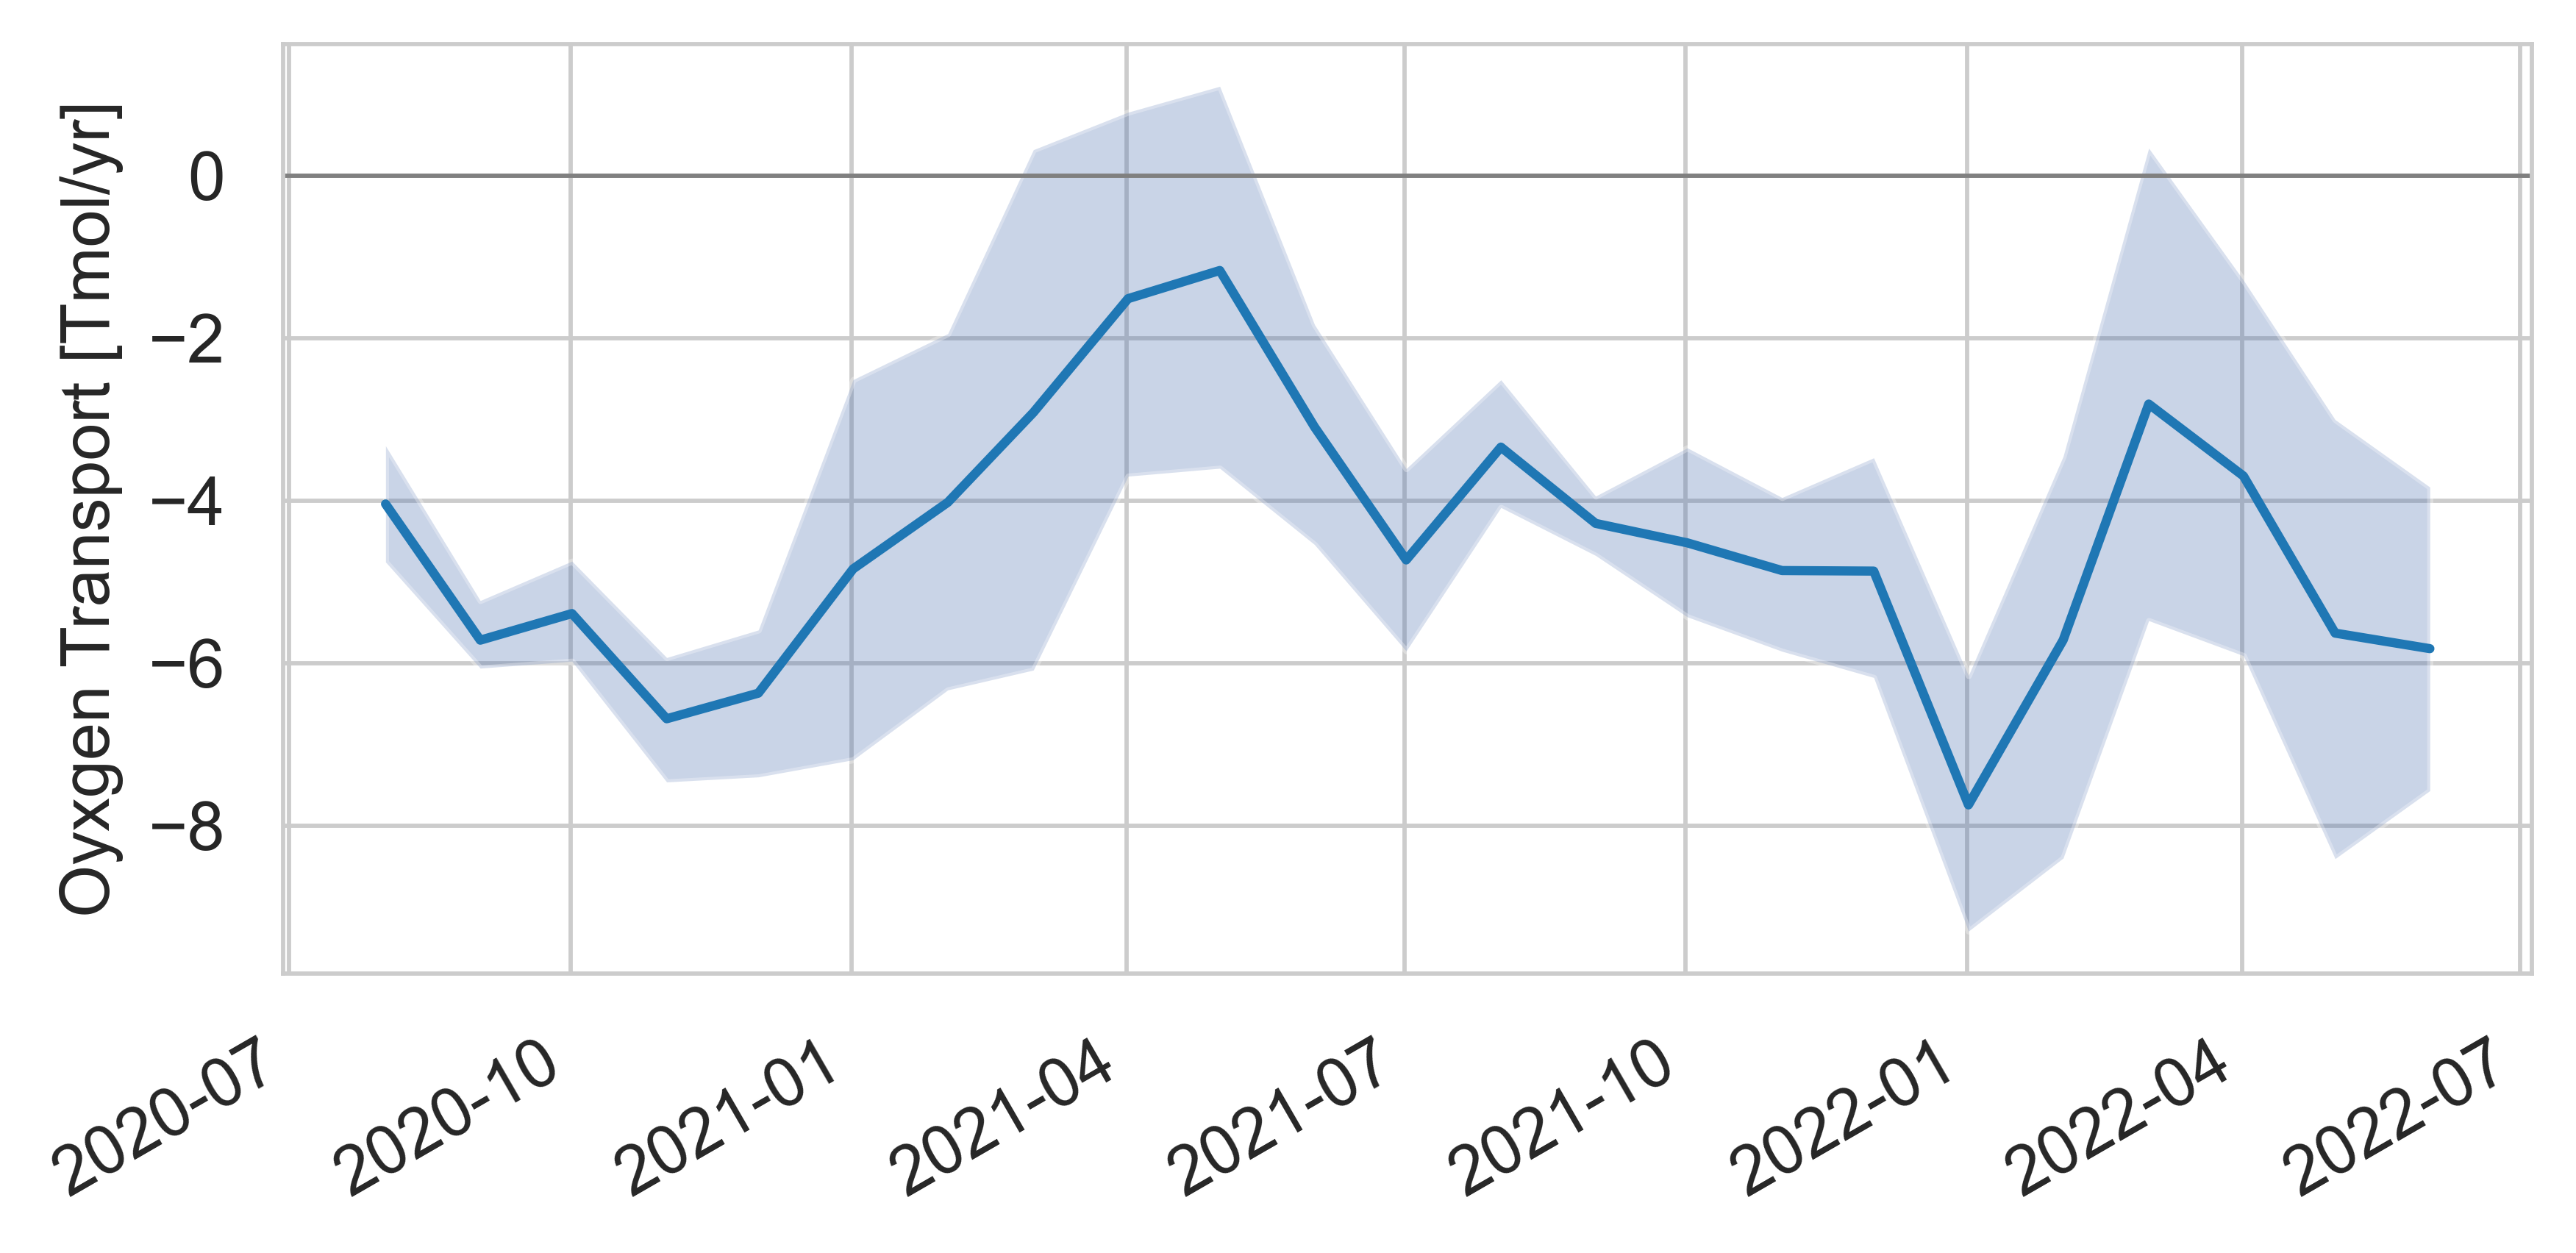

In [1020]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 0.7

plt.figure(figsize=(6, 3), dpi=600) 


plt.fill_between(osnap.TIME[:-1],np.nanmean(tmp2,axis = 0)[:-1] - np.nanstd(tmp2,axis = 0)[:-1], np.nanmean(tmp2,axis = 0)[:-1] + np.nanstd(tmp2,axis = 0)[:-1], alpha = 0.3)
# plt.fill_between(osnap.TIME[:-1],np.nanmean(tmp3,axis = 0)[:-1] - np.nanstd(tmp3,axis = 0)[:-1], np.nanmean(tmp3,axis = 0)[:-1] + np.nanstd(tmp3,axis = 0)[:-1], 
#                  edgecolor='none', linewidth=0, alpha = 0.3, zorder = 2)

#plt.plot(osnap.TIME[:-1],np.nanmean(tmp2,axis = 0)[:-1] , color ='tab:orange')

#plt.plot(osnap.TIME[:-1],np.nanmean(tmp2,axis = 0)[:-1], color='tab:orange' )
osnap.TIME[:-1],osnap.OXY_TRANSPORT.sum(dim = 'LONGITUDE').sum(dim='DEPTH')[:-1].plot( color = 'tab:blue')

plt.ylabel('Oyxgen Transport [Tmol/yr]', fontsize = 11)


#plt.fill_between(osnap.TIME,np.nanmean(isopycnal_transport,axis = 0)[:,-1] - np.nanstd(isopycnal_transport,axis = 0)[:,-1], np.nanmean(isopycnal_transport,axis = 0)[:,-1] + np.nanstd(isopycnal_transport,axis = 0)[:,-1],alpha = 0.3)
#plt.plot(osnap.TIME,np.nanmean(isopycnal_transport,axis = 0)[:,-1], color = 'tab:orange')

#plt.fill_between(osnap.TIME,np.nanmean(overturning_transport,axis = 0)[:,-1] - np.nanstd(overturning_transport,axis = 0)[:,-1], np.nanmean(overturning_transport,axis = 0)[:,-1] + np.nanstd(overturning_transport,axis = 0)[:,-1],alpha = 0.3)
#plt.plot(osnap.TIME,np.nanmean(overturning_transport,axis = 0)[:,-1], color = 'tab:green')

#plt.plot(osnap.TIME,np.nanmean(overturning_transport,axis = 0)[:,-1] + np.nanmean(isopycnal_transport,axis = 0)[:,-1], color = 'tab:green')

plt.axhline(0, color = 'grey', linewidth = 0.7)
plt.grid(linewidth=0.7)
plt.xlabel('')

plt.tight_layout()

plt.savefig(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Figures\Transport manuscript\transport_uncertainties.png')

In [1028]:
np.nanstd(tmp2,axis = 0)[:-1]

array([0.71497975, 0.41616402, 0.61635894, 0.76593541, 0.90458683,
       2.34103031, 2.19402288, 3.204409  , 2.24132335, 2.35196385,
       1.35479953, 1.12223913, 0.78609303, 0.36549595, 1.04064651,
       0.94679493, 1.35243632, 1.57378518, 2.47362448, 2.90959244,
       2.31231038, 2.70349655, 1.8694418 ])

In [1032]:
print('24-month average net transport: '+ str(np.nanmean(np.nanmean(tmp2,axis = 0)[:-1])))
print('24-month standard devation: ' + str(np.nanmean(np.nanstd(tmp2,axis = 0)[:-1])))

24-month average net transport: -4.508069336154123
24-month standard devation: 1.5896317644231877


# Calculate overturning and isopycnal componants

### Regrid in density space

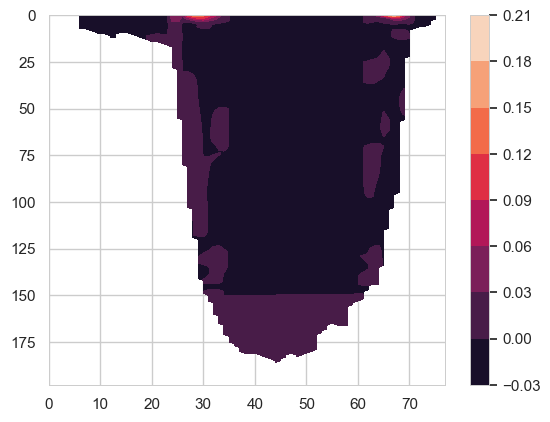

In [709]:
osnap_old = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\O2_mol_yr_Oct_19_amoc_isopycnal_with_dx_and_velocity.nc') #monthly osnap grids
osnap_old = osnap_old.assign_coords({'distance': osnap_old.longitude})

i = 2
plt.contourf(oxygen_grid.sel(TIME = oxygen_grid.TIME[i]).SIGMA0.values - osnap_old.sel(time = osnap_old.time[i+1]).rho0.values)
plt.colorbar()
plt.gca().invert_yaxis()

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [953]:


V_global = osnap.VELO_ZEROSUM#.isel(time=slice(1, None))
V_error_global = osnap_daily.velocity.resample(TIME='M').std()/np.sqrt(30/(2*tau))
bins_rho0 = np.arange(1024.53, 1027.95, 0.01)

O_global = (oxygen_grid.DOXY + oxygen_grid.DOXY_BIAS_WOA)*oxygen_grid.SIGMA0 #convert from umol/kg to umol/m3 by multiplying by density
O_error_global = oxygen_grid.DOXY_ERROR_TOTAL



#overturning_transport = []
#isopycnal_transport = []


for it in np.arange(100):

    
    if it % 2 == 0:
        
        gc.collect()
    
    if it % 5 == 0:
        print(f"Starting iteration {it}")
        

    

    
    #counts = np.zeros([78,len(bins_rho0),24])
    #velo_rho_sorted = np.zeros([78,len(bins_rho0),24])

  
    volume_flux_rho_sorted =  np.zeros([78,len(bins_rho0),24])
    oxy_rho_sorted = np.zeros([78,len(bins_rho0),24])
    velo_rho_sorted = np.zeros([78,len(bins_rho0),24])
    counts = np.zeros([78,len(bins_rho0),25])
            
    # Use pre-loaded global data
    V = V_global
    O = O_global
    O_error = O_error_global
    V_error = V_error_global

    #V_montecarlo_full = np.random.normal(V, V_error.values)
    V_montecarlo_full = V.values + V_error.values*np.random.normal()
    O_montecarlo_full = O.values + O_error*np.random.normal()



    #V_montecarlo_full = V.values + V_error.values*np.random.normal()

    for i in range(len(oxygen_grid.TIME)):
                    
        #rng = np.random.default_rng()    
        #V_montecarlo_full = V.values[i,:,:] + V_error.values[i,:,:] * np.random.normal() #np.random.standard_normal(1) #*np.random.random(1) 

        
        
        # Volume flux must sum to zero      
        
        d = 1e10
        correction_guess = np.linspace(-0.001,0.001)


        #i = 5
        while np.abs(d) > 10000: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
                    
                    tmp_sum = []  
                    for c_i in correction_guess:
                        
                        tmp_sum.append(np.nansum((V_montecarlo_full[i,:,:] + c_i) * osnap_daily.grid_factor.values))   
                        
            
                    ix = np.argmin(np.abs(tmp_sum))
                    d = np.nanmin(np.abs(tmp_sum))
                    correction = correction_guess[ix]
                    
                    correction_guess = np.linspace(correction_guess[ix] - 0.0001 , correction_guess[ix] + 0.0001)

                    
        max_iter = 1000
        n_iter = 0
        
        while np.abs(d) > 50 and n_iter < max_iter: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
                    n_iter += 1
                    tmp_sum = []  
                    for c_i in correction_guess:
                        
                        tmp_sum.append(np.nansum((V_montecarlo_full[i,:,:]  + c_i) * osnap_daily.grid_factor.values))   
                        
            
                    ix = np.argmin(np.abs(tmp_sum))
                    d = np.nanmin(np.abs(tmp_sum))
                    correction = correction_guess[ix]
                    
                    correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)


        for j in range(len(oxygen_grid.LONGITUDE)): # sort by density for one column of data at a time b/c digitize can't do matrix

            

            V_i = V_montecarlo_full[i,:,:] + correction
            tmp = osnap_old.sel(time = osnap_old.time[i+1]).rho0.sel(distance = osnap_old.distance[j]).values

        
            O_i = O_montecarlo_full[i,:,j]



            #V_montecarlo = V_montecarlo_full[i,:,j] #V_montecarlo_full[i,:,j]
            bins = bins_rho0


            id = np.digitize(tmp, bins)


            
            tmp2 = np.zeros(len(bins))
            tmp3 = np.zeros(len(bins))
            tmp4 = np.zeros(len(bins))
            tmp5 = np.zeros(len(bins))


            volume_flux = V_i[:,j] * osnap_daily.grid_factor[j].values

            
            for ii in np.unique(id[id != len(bins)]): #nans go into bin that is len(bins)

                tmp2[ii] = np.nanmean(V_i[:,j][id == ii])
                tmp3[ii] = np.nanmean(O_i[id == ii])
                O_tmp = O_i[id == ii]
                tmp4[ii] = len(O_tmp[~np.isnan(O_tmp)])
                tmp5[ii] = np.nansum(volume_flux[id == ii])
    

            tmp2[tmp2 == 0] = np.nan
            tmp3[tmp3 == 0] = np.nan
            tmp4[tmp4 == 0] = np.nan
            volume_flux_rho_sorted[j,:,i] = tmp5

            counts[j,:,i] = tmp4
            velo_rho_sorted[j,:,i] = tmp2
            oxy_rho_sorted[j,:,i] = tmp3
            counts[j,:,i] = tmp4


    sigma_bins = counts * 20


    overturning_transport_cumsum = []
    isopycnal_transport_cumsum = []

    a = []
    b = []


    
    d_sigma = np.nanmean(sigma_bins,axis=0)

    for i in np.arange(24):
                
        a = (oxy_rho_sorted[:,:,i] - np.nanmean(oxy_rho_sorted[:,:,i], axis =0)) * (velo_rho_sorted[:,:,i] - np.nanmean(velo_rho_sorted[:,:,i], axis =0))
        x_integral = []
        
        for j in np.arange(len(d_sigma)): #integrate over x

            x_integral.append(np.nansum(a[:,j].reshape(78,1)* (osnap_daily.grid_factor.values.reshape(78,1)/20)))

        isopycnal_transport_cumsum.append(np.nancumsum(x_integral * d_sigma[:,i])*1e-6*1e-12*3.15576e+7)


        b = np.nanmean(oxy_rho_sorted[:,:,i],axis = 0)*1e-6*1e-12  * np.nansum((volume_flux_rho_sorted[:, :, i]), axis = 0) *3.15576e+7
        overturning_transport_cumsum.append(np.nancumsum(b))



            

    overturning_transport.append(np.array(overturning_transport_cumsum))

    isopycnal_transport.append(np.array(isopycnal_transport_cumsum))
    #overturning_vol.append(np.array(np.nanmean(overturning_vol_cumsum,axis = 0))) #average over year

    



Starting iteration 0
Starting iteration 5
Starting iteration 10
Starting iteration 15
Starting iteration 20
Starting iteration 25
Starting iteration 30
Starting iteration 35
Starting iteration 40
Starting iteration 45
Starting iteration 50


KeyboardInterrupt: 

In [968]:
xr.Dataset(

    data_vars=dict(

        overturning=(["realization", "TIME", "density"], overturning_transport),

        isopycnal=(["realization", "TIME", "density"], isopycnal_transport),

    ),

    coords=dict(

 
        realization=np.arange(np.shape(isopycnal_transport)[0]),

        TIME=osnap.TIME,

        density=bins_rho0 ,

    ),

    attrs=dict(description="Overturning and isopycnal componants of Labrador Sea oxygen transport [Tmol/yr]"),

).to_netcdf(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\iso_overturing_oxy_transport.nc')

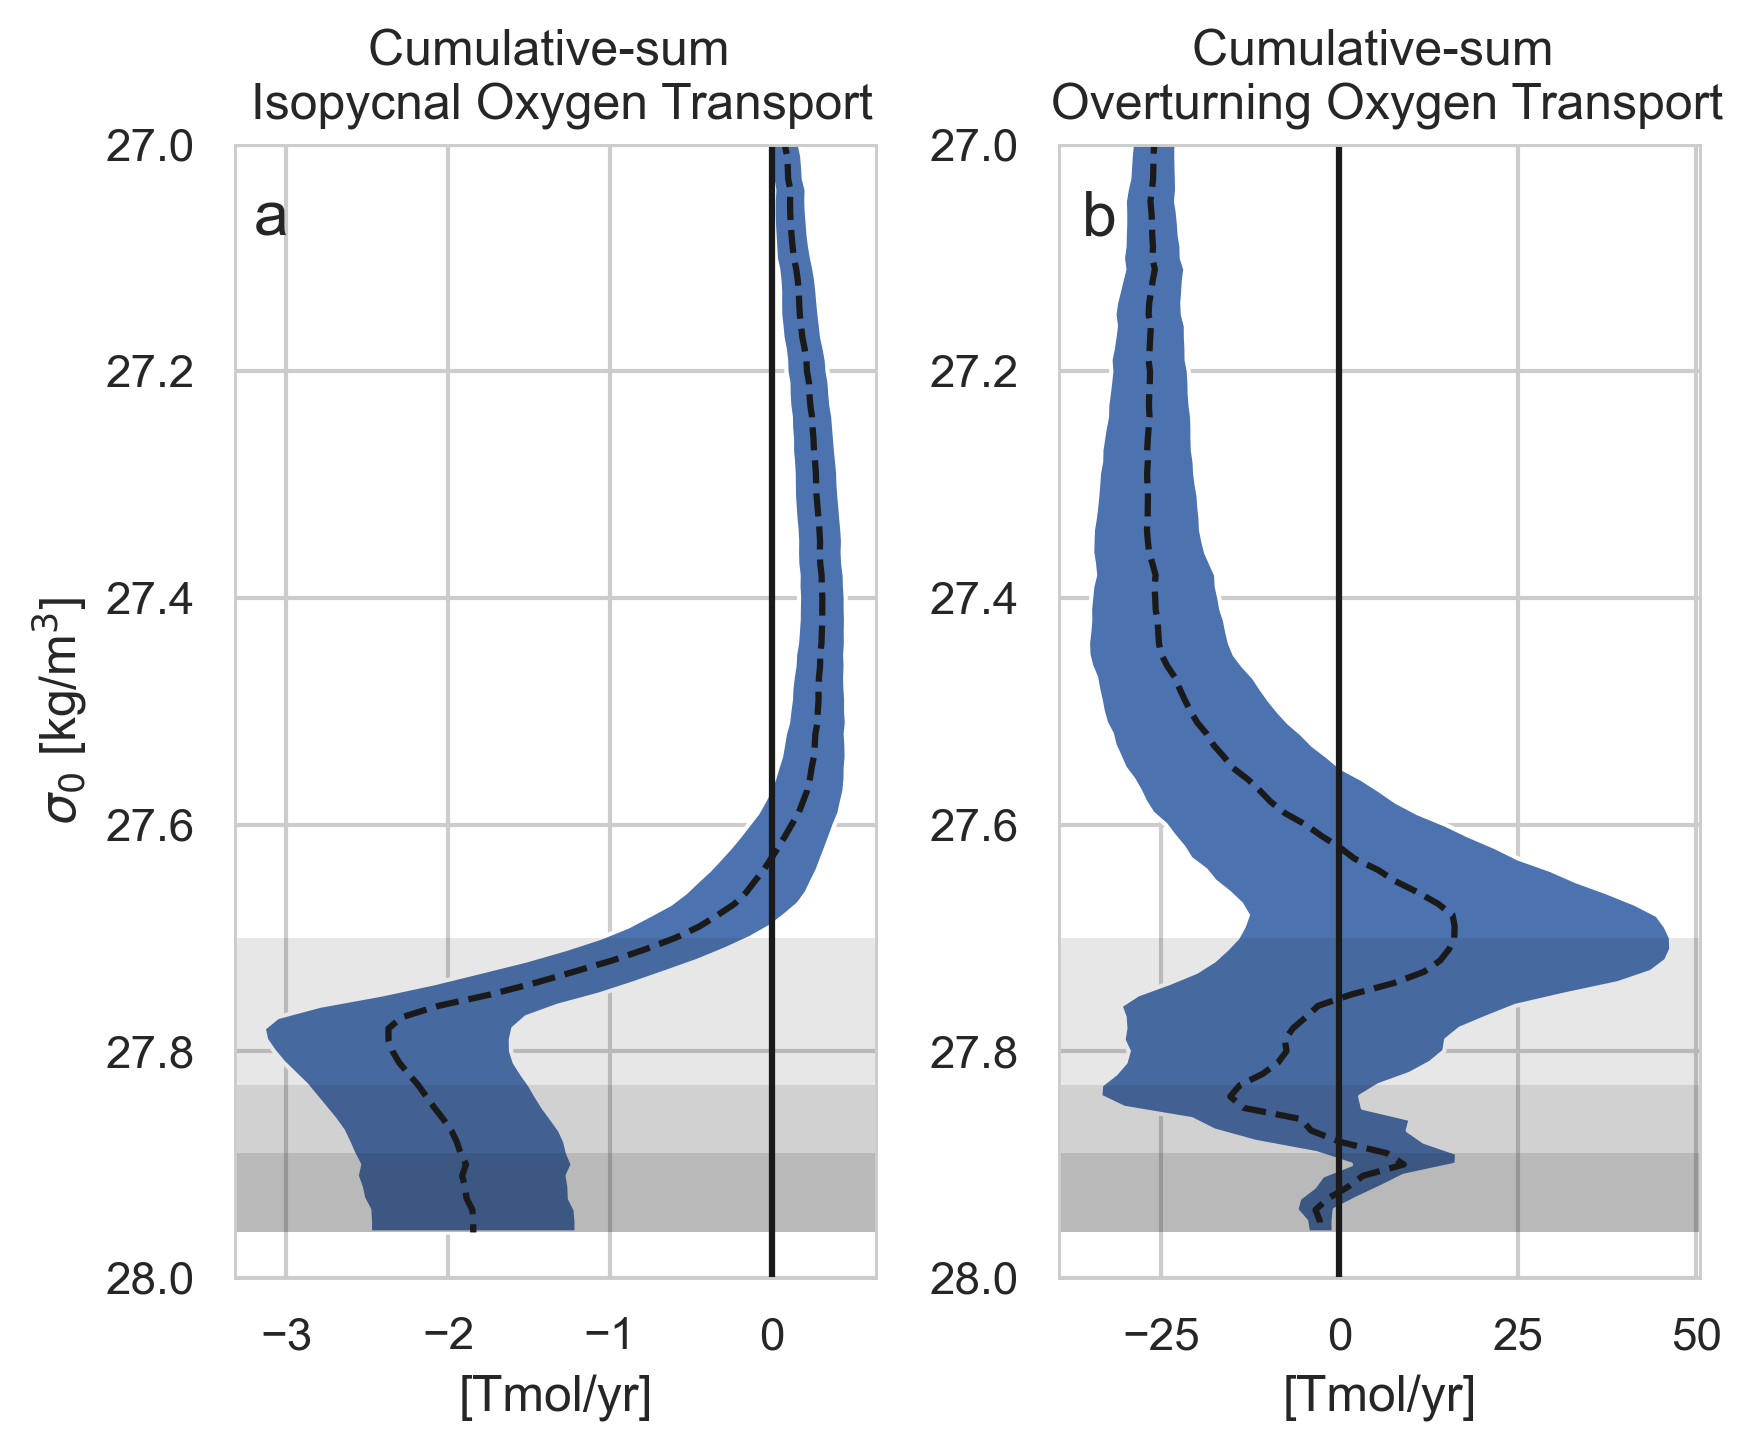

In [1043]:
plt.figure(figsize = ((6,5)), dpi = 300)

plt.subplot(1,2,2)


bins_rho0 = density = np.arange(1024.54, 1027.96, 0.01) - 1000


# for i in np.arange(24):
#     if i in [0,1,11, 12, 13, 23 ,24]:
#         color = 'tab:olive'
#     elif i in [2,3,4, 14,15,16]:
#         color = 'tab:orange'
#     elif i in [5,6,7,17,18,19, 29,30,31]:
#         color = 'tab:blue'
#     else:
#         color = 'tab:green'
#     plt.plot(np.array(overturning_transport_cumsum)[i,:]*1e-6*3.15576e+7*1e-12, bins_rho0 - 1000, color = color, linewidth = 0.001)
plt.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'k', linestyle='dashed', label='0.01 kg/m3')

x1 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
plt.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2  )


plt.gca().invert_yaxis()

#plt.legend(loc =1)

plt.ylim([28, 27])


plt.axhspan(27.7, 27.83, color = 'k', alpha = 0.1, lw=0) #27.69
plt.axhspan(27.83, 27.89, color = 'k', alpha = 0.2, lw=0)
plt.axhspan(27.89, 27.96, color = 'k', alpha = 0.3, lw=0)
#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

#plt.axhline(27.83, color = 'k', linestyle = 'dashed', linewidth = 0.5)
plt.axvline(0, color = 'k')

# plt.axvline(-26.297)
# plt.axvline(-8)
# plt.axvline(-15)
# plt.axvline(8)

plt.xlabel('[Tmol/yr]')

plt.text(-36, 27.08, 'b', fontsize = 15)

plt.title('Cumulative-sum \n Overturning Oxygen Transport')

plt.subplot(1,2,1) ##################

plt.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'k', linestyle='dashed', label='0.01 kg/m3')

x1 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
plt.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2  )

plt.gca().invert_yaxis()

plt.ylim([28, 27])

plt.axhspan(27.7, 27.83, color = 'k', alpha = 0.1, lw=0) #27.69
plt.axhspan(27.83, 27.89, color = 'k', alpha = 0.2, lw=0)
plt.axhspan(27.89, 27.96, color = 'k', alpha = 0.3, lw=0)
#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

plt.axvline(0, color = 'k')
# plt.axvline(-0.2)
# plt.axvline(-2.05)
plt.xlabel('[Tmol/yr]')
plt.title('Cumulative-sum \n Isopycnal Oxygen Transport')

plt.text(-3.2, 27.08, 'a', fontsize = 15)

plt.ylabel('$\sigma _{0}$ [kg/m$^{3}$]')

plt.tight_layout()
plt.subplots_adjust(hspace= 0.1)


plt.savefig(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Figures\Transport manuscript\iso_OT_cumsum.png')

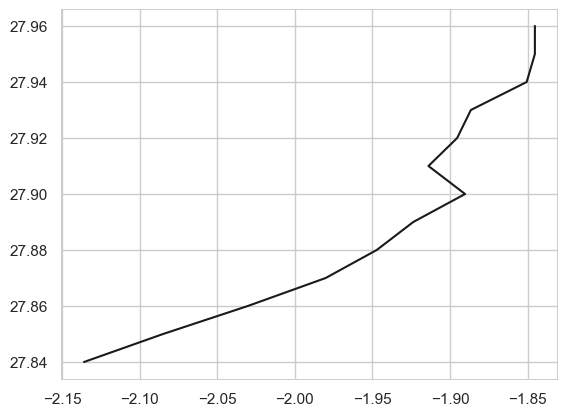

In [1104]:
plt.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0)[330:350], np.arange(1024.54, 1027.96, 0.01)[330:350]-1000, color = 'k')

#plt.gca().invert_yaxis()

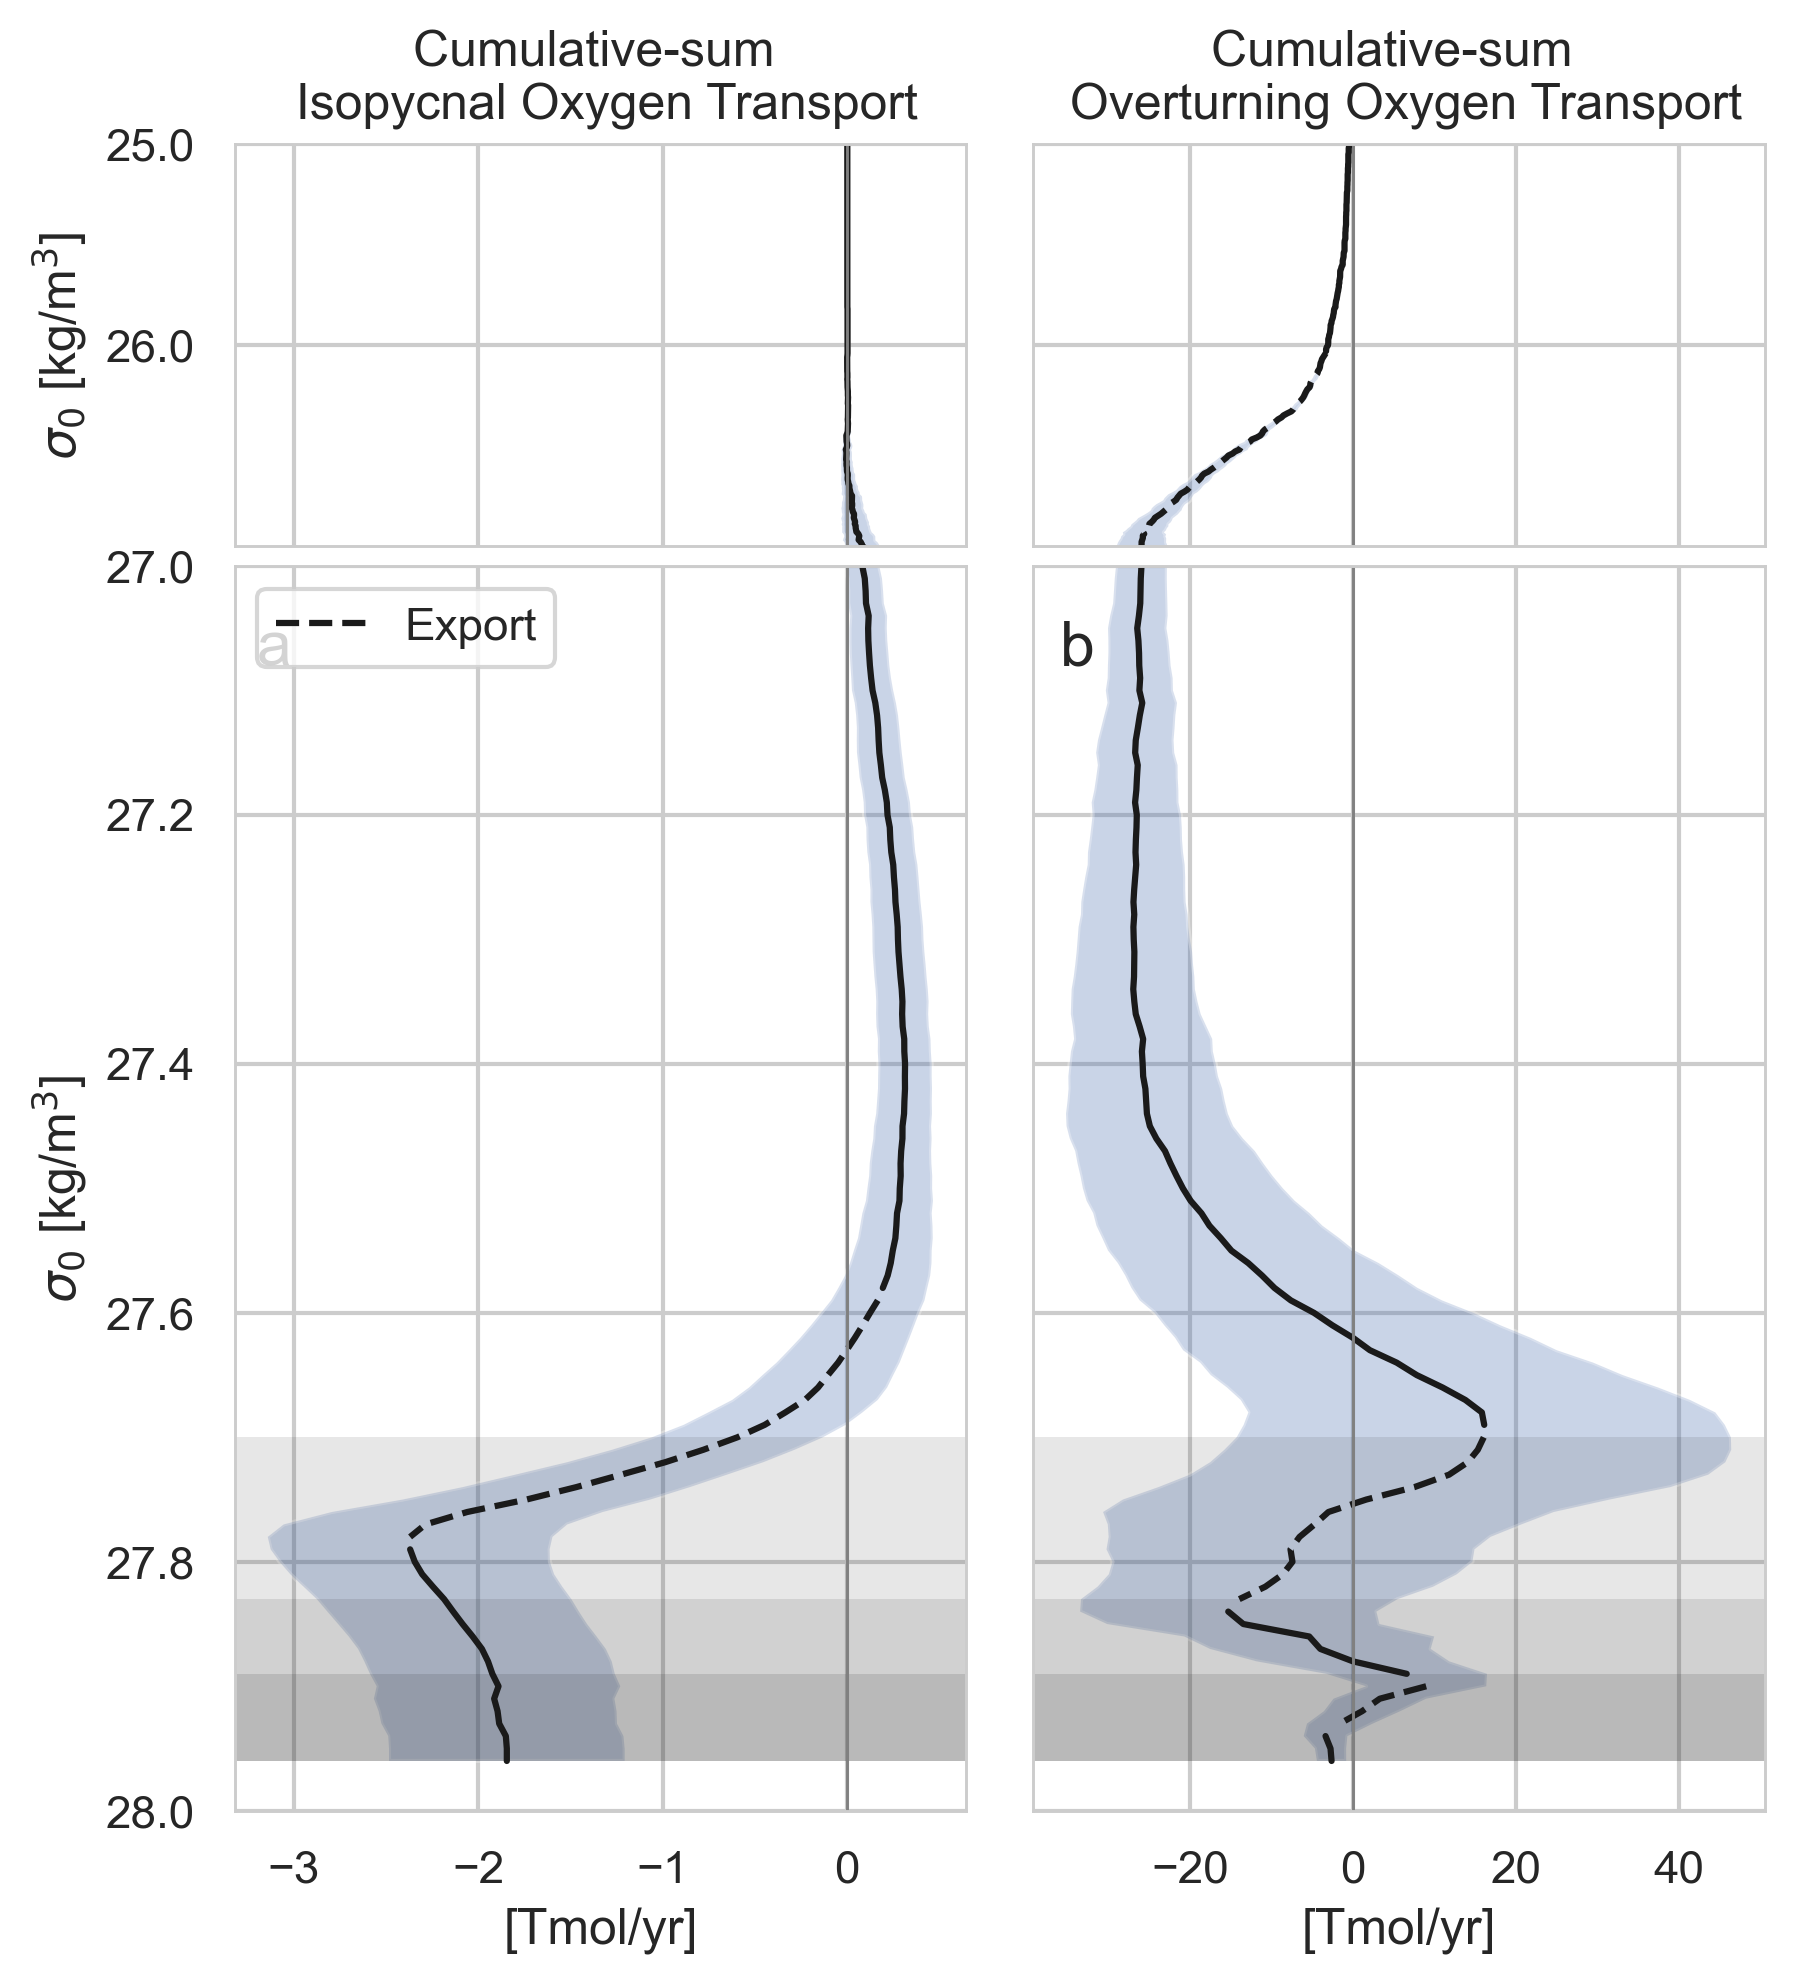

In [1147]:
fig = plt.figure(figsize = ((6,8)), dpi = 300)

gs = gridspec.GridSpec(5, 4)
mpl.rcParams['axes.linewidth'] = 0.7

bins_rho0 = density = np.arange(1024.54, 1027.96, 0.01) - 1000


ax1 = fig.add_subplot(gs[0, 0:2])  ################################### top left


ax1.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'k')


x1 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
ax1.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2 , alpha = 0.3)



ax1.invert_yaxis()

ax1.set_ylim([27, 25])

ax1.set_yticks([26,25]) 
ax1.set_yticklabels([26.0,25.0])


ax1.set_xticklabels([])

#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

ax1.axvline(0, color = 'grey', linewidth = 0.7)
# plt.axvline(-0.2)
# plt.axvline(-2.05)

ax1.set_title('Cumulative-sum \n Isopycnal Oxygen Transport')

#plt.text(-3.2, 27.08, 'a', fontsize = 15)

ax1.set_ylabel('$\sigma _{0}$ [kg/m$^{3}$]')


ax2 = fig.add_subplot(gs[0, 2:4]) ################################### top right

ax2.set_title('Cumulative-sum \n Overturning Oxygen Transport')

#ax2.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'k', linestyle='dashed', label='0.01 kg/m3')
ax2.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[:150], np.arange(1024.54, 1027.96, 0.01)[:150]-1000, color = 'k')
ax2.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[150:], np.arange(1024.54, 1027.96, 0.01)[150:]-1000, color = 'k', linestyle = 'dashed')

x1 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
ax2.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2 , alpha = 0.3 )


ax2.invert_yaxis()

#plt.legend(loc =1)
ax2.set_ylim([27, 25]) 

#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

#plt.axhline(27.83, color = 'k', linestyle = 'dashed', linewidth = 0.5)
ax2.axvline(0, color = 'grey', linewidth = 0.7)

# plt.axvline(-26.297)
# plt.axvline(-8)
# plt.axvline(-15)
# plt.axvline(8)

ax2.set_yticks([26,25]) 

ax2.set_xticklabels([])
ax2.set_yticklabels([])
#plt.text(-36, 27.08, 'b', fontsize = 15)







ax3 = fig.add_subplot(gs[1:4, 0:2]) ################################## bottom left

#ax3.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'k', label='0.01 kg/m3')
ax3.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0)[:305], np.arange(1024.54, 1027.96, 0.01)[:305]-1000, color = 'k')
ax3.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0)[305:325], np.arange(1024.54, 1027.96, 0.01)[305:325]-1000, color = 'k', linestyle='dashed', label = 'Export')
ax3.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0)[325:], np.arange(1024.54, 1027.96, 0.01)[325:]-1000, color = 'k')

x1 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
ax3.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2, alpha = 0.3  )

ax3.invert_yaxis()

ax3.set_ylim([28, 27])

ax3.axhspan(27.7, 27.83, color = 'k', alpha = 0.1, lw=0) #27.69
ax3.axhspan(27.83, 27.89, color = 'k', alpha = 0.2, lw=0)
ax3.axhspan(27.89, 27.96, color = 'k', alpha = 0.3, lw=0)
#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

ax3.axvline(0, color = 'grey', linewidth = 0.7)
# plt.axvline(-0.2)
# plt.axvline(-2.05)
ax3.set_xlabel('[Tmol/yr]')


ax3.text(-3.2, 27.08, 'a', fontsize = 15)

ax3.set_ylabel('$\sigma _{0}$ [kg/m$^{3}$]')

ax3.legend()

ax4 = fig.add_subplot(gs[1:4, 2:4]) ################################## bottom right




#ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'k', linestyle='dashed', label='0.01 kg/m3')

ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[:316], np.arange(1024.54, 1027.96, 0.01)[:316]-1000, color = 'k')
ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[316:330], np.arange(1024.54, 1027.96, 0.01)[316:330]-1000, color = 'k', linestyle='dashed')
ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[330:336], np.arange(1024.54, 1027.96, 0.01)[330:336]-1000, color = 'k')
ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[336:-3], np.arange(1024.54, 1027.96, 0.01)[336:-3]-1000, color = 'k',  linestyle='dashed')
ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[-3:], np.arange(1024.54, 1027.96, 0.01)[-3:]-1000, color = 'k')


x1 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
ax4.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2, alpha = 0.3  )


ax4.invert_yaxis()

#plt.legend(loc =1)

ax4.set_ylim([28, 27])
 
ax4.axhspan(27.7, 27.83, color = 'k', alpha = 0.1, lw=0) #27.69
ax4.axhspan(27.83, 27.89, color = 'k', alpha = 0.2, lw=0)
ax4.axhspan(27.89, 27.96, color = 'k', alpha = 0.3, lw=0)


#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

#plt.axhline(27.83, color = 'k', linestyle = 'dashed', linewidth = 0.5)
ax4.axvline(0, color = 'grey', linewidth = 0.7)

# plt.axvline(-26.297)
# plt.axvline(-8)
# plt.axvline(-15)
# plt.axvline(8)

ax4.set_xlabel('[Tmol/yr]')

ax4.text(-36, 27.08, 'b', fontsize = 15)


ax4.set_yticklabels([])

#plt.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.2, top=0.95, bottom=0.08, left=0.1, right=0.95)
#plt.subplots_adjust(hspace= 0.005)


plt.savefig(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Figures\Transport manuscript\iso_OT_cumsum.png')

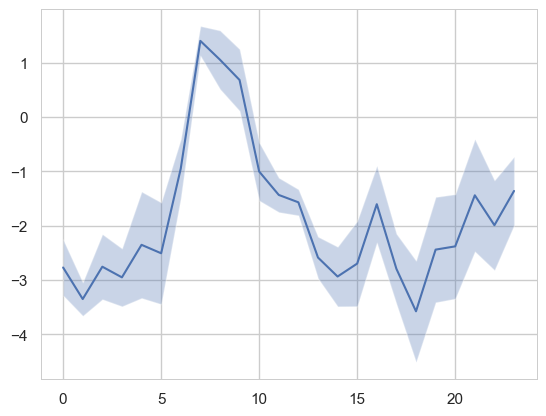

In [991]:

plt.fill_between(np.arange(24),np.nanmean(isopycnal_transport,axis = 0)[:,-1] - np.nanstd(isopycnal_transport,axis = 0)[:,-1], np.nanmean(isopycnal_transport,axis = 0)[:,-1] + np.nanstd(isopycnal_transport,axis = 0)[:,-1],alpha = 0.3
                 )
plt.plot(np.arange(24),np.nanmean(isopycnal_transport,axis = 0)[:,-1])

In [1034]:
print(np.nanmean(np.nanmean(isopycnal_transport,axis = 0)[:,-1]))
print(np.nanmean(np.nanstd(isopycnal_transport,axis = 0)[:,-1]))

-1.8452316068797237
0.6385646864995117


In [1035]:
1.8/4.5

0.4

In [1036]:
print(np.nanmean(np.nanmean(overturning_transport,axis = 0)[:,-1]))
print(np.nanmean(np.nanstd(overturning_transport,axis = 0)[:,-1]))

-2.6040787985776976
1.7974973643585834


In [1040]:
-1.8452316068797237/ (-1.8452316068797237  -2.6040787985776976)

0.414723055648445

In [1039]:
-1.8452316068797237/-4.508069336154123

0.4093174858871865